# Atmospheric composition distribution by CAMS and TROPOMI

### Main goal:
* Compare TROPOMI and CAMS datasets for NO<sub>2</sub>, CO, O<sub>3</sub> and SO<sub>2</sub> (Level 2).

## Imports and supporting functions

In [1]:
import os 
from sentinelsat.sentinel import SentinelAPI, geojson_to_wkt
import cdsapi
import cfgrib
import xarray as xr
import pandas as pd
import numpy as np
from itertools import product
import scipy.interpolate
from copy import copy
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import math
import geojson
from sklearn.linear_model import LinearRegression
from scipy.spatial.distance import cdist
import datetime as dt
import geocoder
import seaborn as sns
from matplotlib.cbook import boxplot_stats  

In [2]:
%run functions/functions_general.ipynb
%run functions/functions_cams.ipynb
%run functions/functions_tropomi.ipynb

In [3]:
# Hide pandas warning
pd.options.mode.chained_assignment = None

## 1. Define datasets

In [4]:
# Define component
component_nom = 'NO2'

# Define sensor
sensor = 'tropomi'
sensor_type = 'L2'

# Define model
model = 'cams'
model_full_name = 'cams-global-atmospheric-composition-forecasts'

# Check if comparison is possible
comparison_check(sensor, model, component_nom, model_full_name, sensor_type)

# Get component full name and molecular weight
component, component_mol_weight, product_type, sensor_column = components_table(sensor, component_nom)

# Folders generation
generate_folders(model, sensor, component_nom)

The comparison is possible and will start now.


In [5]:
# Define extent
lon_min = 12
lon_max = 18.9
lat_min = 48.5
lat_max = 51.1

# Create bbox
bbox = ((lon_min, lat_min), (lon_max, lat_max))

# Define search period
start_date = '2021-09-01'
end_date = '2021-09-02'
dates = search_period(start_date, end_date, sensor, sensor_type)

SEARCH PERIOD
- In days: [('2021-09-01T00:00:00Z', '2021-09-01T23:00:00Z'), ('2021-09-02T00:00:00Z', '2021-09-02T23:00:00Z')]


## 2. Model data

### Download and read data as xarray

In [6]:
model_product_name, model_type = CAMS_download(dates, start_date, end_date, component, 
                                               component_nom, model_full_name, model_level = 'Multiple')

2021-09-21 19:30:52,459 INFO Welcome to the CDS
2021-09-21 19:30:52,460 INFO Sending request to https://ads.atmosphere.copernicus.eu/api/v2/resources/cams-global-atmospheric-composition-forecasts
2021-09-21 19:30:52,472 INFO Request is queued


The file does not exist, it will be downloaded.


2021-09-21 19:30:53,481 INFO Request is running
2021-09-21 19:32:07,484 INFO Request is completed
2021-09-21 19:32:07,485 INFO Downloading https://download-0003.copernicus-atmosphere.eu/cache-compute-0003/cache/data1/adaptor.mars_constrained.internal-1632252718.9749842-13098-16-760be384-35d3-44e5-b841-7a0b7d110d94.grib to data/cams/NO2/NO2-hourly-levels-2021-09-01-2021-09-02.grib (1.2G)
2021-09-21 19:32:29,747 INFO Download rate 57.2M/s


In [7]:
model_ds, _ = CAMS_read(model_product_name, component, component_nom, dates)
model_ds

<xarray.Dataset>
Dimensions:     (hybrid: 137, latitude: 451, longitude: 900, step: 4, time: 2)
Coordinates:
  * time        (time) datetime64[ns] 2021-09-01 2021-09-02
  * step        (step) timedelta64[ns] 00:00:00 06:00:00 12:00:00 18:00:00
  * hybrid      (hybrid) float64 1.0 2.0 3.0 4.0 5.0 ... 134.0 135.0 136.0 137.0
  * latitude    (latitude) float64 -90.0 -89.6 -89.2 -88.8 ... 89.2 89.6 90.0
  * longitude   (longitude) float64 -180.0 -179.6 -179.2 ... 178.8 179.2 179.6
    valid_time  (time, step) datetime64[ns] ...
Data variables:
    component   (time, step, hybrid, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-09-21T19:32 GRIB to CDM+CF via cfgrib-0.9.9...

### Collect 137 levels model data

In [8]:
model_levels_df = CAMS_137_levels()
model_levels_df

,a [Pa],b,ph [hPa],pf [hPa],Geopotential Altitude [m],Geometric Altitude [m],Temperature [K],Density [kg/m^3],ph [Pa],ph-diff [Pa],Depth [m]
hybrid,,,,,,,,,,,
1,2.000365,0.000000,0.0200,0.0100,79301.79,80301.65,198.05,0.000018,2.00,2.00,5580.21
2,3.102241,0.000000,0.0310,0.0255,73721.58,74584.91,209.21,0.000042,3.10,1.10,2605.83
3,4.666084,0.000000,0.0467,0.0388,71115.75,71918.79,214.42,0.000063,4.67,1.57,2497.32
4,6.827977,0.000000,0.0683,0.0575,68618.43,69365.77,221.32,0.000090,6.83,2.16,2407.44
5,9.746966,0.000000,0.0975,0.0829,66210.99,66906.53,228.06,0.000127,9.75,2.92,2320.96
...,...,...,...,...,...,...,...,...,...,...,...
133,62.781250,0.988500,1002.2250,1000.5165,106.54,106.54,287.46,1.212498,100222.50,341.69,27.50
134,22.835938,0.991984,1005.3562,1003.7906,79.04,79.04,287.64,1.215710,100535.62,313.12,25.12
135,3.757813,0.995003,1008.2239,1006.7900,53.92,53.92,287.80,1.218650,100822.39,286.77,22.96


### Convert CAMS data units (kg/kg to molecules/cm<sup>2</sup>)

In [9]:
model_ds, units = model_convert_units(model_ds, model, component_mol_weight, component, conversion_method = 'Simple')

The model component units have been converted from kg kg**-1 to kg m**-2.
The model component units have been converted from kg m**-2 to molec cm-2.


### Download read and subset original total columns data

In [10]:
model_product_name, model_type = CAMS_download(dates, start_date, end_date, component, component_nom, 
                                               model_full_name, model_level = 'Single')
model_total_ds, _ = CAMS_read(model_product_name, component, component_nom, dates)
model_total_ds = subset(model_total_ds, bbox)
model_total_ds

The file exists, it will not be downloaded again.


<xarray.Dataset>
Dimensions:     (latitude: 8, longitude: 18, step: 4, time: 2)
Coordinates:
    number      int64 ...
  * time        (time) datetime64[ns] 2021-09-01 2021-09-02
  * step        (step) timedelta64[ns] 00:00:00 06:00:00 12:00:00 18:00:00
    surface     float64 ...
  * latitude    (latitude) float64 48.4 48.8 49.2 49.6 50.0 50.4 50.8 51.2
  * longitude   (longitude) float64 12.0 12.4 12.8 13.2 ... 17.6 18.0 18.4 18.8
    valid_time  (time, step) datetime64[ns] ...
Data variables:
    component   (time, step, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-09-21T19:32 GRIB to CDM+CF via cfgrib-0.9.9...

### Convert CAMS total columns data units (kg/m2 to molecules/cm<sup>2</sup>)

In [11]:
model_total_ds, _ = model_convert_units(model_total_ds, model, component_mol_weight, component, conversion_method = 'Simple')

The model component units have been converted from kg m**-2 to molec cm-2.


## 3. Sensor data

### Download and read data as xarray

In [12]:
# This won't work if the search period is older than one month
sensor_product_names = sensor_download(sensor, sensor_type, component_nom, bbox, dates, product_type)

You can see all the results at https://s5phub.copernicus.eu/dhus/.


2021-09-21 19:32:50,989 INFO Found 1 products


RESULTS FOR PERIOD ('2021-09-01T00:00:00Z', '2021-09-01T23:00:00Z')
Number 0-S5P_NRTI_L2__NO2____20210901T115209_20210901T115709_20133_02_020200_20210901T125348
SELECTED
File name: 114e3a35-cab6-432f-987f-e68b5f60be69
Product name: S5P_NRTI_L2__NO2____20210901T115209_20210901T115709_20133_02_020200_20210901T125348.nc
The file does not exist, it will be downloaded.


2021-09-21 19:32:55,035 INFO Downloading 114e3a35-cab6-432f-987f-e68b5f60be69 to data/tropomi/NO2/S5P_NRTI_L2__NO2____20210901T115209_20210901T115709_20133_02_020200_20210901T125348.nc


Downloading:   0%|          | 0.00/62.8M [00:00<?, ?B/s]

MD5 checksumming:   0%|          | 0.00/62.8M [00:00<?, ?B/s]

You can see all the results at https://s5phub.copernicus.eu/dhus/.


2021-09-21 19:33:10,572 INFO Found 1 products


RESULTS FOR PERIOD ('2021-09-02T00:00:00Z', '2021-09-02T23:00:00Z')
Number 0-S5P_NRTI_L2__NO2____20210902T113209_20210902T113709_20147_02_020200_20210902T123346
SELECTED
File name: 061b9487-3a95-49d3-abab-f606632a80eb
Product name: S5P_NRTI_L2__NO2____20210902T113209_20210902T113709_20147_02_020200_20210902T123346.nc
The file does not exist, it will be downloaded.


2021-09-21 19:33:18,557 INFO Downloading 061b9487-3a95-49d3-abab-f606632a80eb to data/tropomi/NO2/S5P_NRTI_L2__NO2____20210902T113209_20210902T113709_20147_02_020200_20210902T123346.nc


Downloading:   0%|          | 0.00/62.8M [00:00<?, ?B/s]

MD5 checksumming:   0%|          | 0.00/62.8M [00:00<?, ?B/s]

In [13]:
sensor_ds, support_input_ds, support_details_ds = sensor_read(sensor, sensor_type, component_nom, sensor_product_names)
sensor_ds

<xarray.Dataset>
Dimensions:                                               (corner: 4, ground_pixel: 450, intensity_offset_polynomial_exponents: 1, layer: 34, polynomial_exponents: 6, scanline: 373, time: 2, vertices: 2)
Coordinates:
  * scanline                                              (scanline) float64 ...
  * time                                                  (time) datetime64[ns] ...
  * ground_pixel                                          (ground_pixel) float64 ...
  * corner                                                (corner) float64 0....
  * polynomial_exponents                                  (polynomial_exponents) float64 ...
  * intensity_offset_polynomial_exponents                 (intensity_offset_polynomial_exponents) float64 ...
  * layer                                                 (layer) float64 0.0...
  * vertices                                              (vertices) float64 ...
    latitude                                              (time, scanline, ground_pixel) float32 ...
    longitude                                             (time, scanline, ground_pixel) float32 ...
Data variables:
    delta_time                                            (time, scanline) datetime64[ns] ...
    time_utc                                              (time, scanline) object ...
    qa_value                                              (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column                   (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column_precision         (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column_precision_kernel  (time, scanline, ground_pixel) float32 ...
    averaging_kernel                                      (time, scanline, ground_pixel, layer) float32 ...
    air_mass_factor_troposphere                           (time, scanline, ground_pixel) float32 ...
    air_mass_factor_total                                 (time, scanline, ground_pixel) float32 ...
    tm5_tropopause_layer_index                            (time, scanline, ground_pixel) float64 ...
    tm5_constant_a                                        (layer, vertices) float32 ...
    tm5_constant_b                                        (layer, vertices) float32 ...

### Convert TROPOMI data units (From mol/m<sup>2</sup> to molecules/cm<sup>2</sup>)

In [14]:
sensor_ds = sensor_convert_units(sensor_ds, sensor_column, sensor, component)
sensor_ds

The sensor component units have been converted from mol cm-2 to molec cm-2.


<xarray.Dataset>
Dimensions:                                               (corner: 4, ground_pixel: 450, intensity_offset_polynomial_exponents: 1, layer: 34, polynomial_exponents: 6, scanline: 373, time: 2, vertices: 2)
Coordinates:
  * scanline                                              (scanline) float64 ...
  * time                                                  (time) datetime64[ns] ...
  * ground_pixel                                          (ground_pixel) float64 ...
  * corner                                                (corner) float64 0....
  * polynomial_exponents                                  (polynomial_exponents) float64 ...
  * intensity_offset_polynomial_exponents                 (intensity_offset_polynomial_exponents) float64 ...
  * layer                                                 (layer) float64 0.0...
  * vertices                                              (vertices) float64 ...
    latitude                                              (time, scanline, ground_pixel) float32 ...
    longitude                                             (time, scanline, ground_pixel) float32 ...
Data variables:
    delta_time                                            (time, scanline) datetime64[ns] ...
    time_utc                                              (time, scanline) object ...
    qa_value                                              (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column                   (time, scanline, ground_pixel) float64 ...
    nitrogendioxide_tropospheric_column_precision         (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column_precision_kernel  (time, scanline, ground_pixel) float32 ...
    averaging_kernel                                      (time, scanline, ground_pixel, layer) float32 ...
    air_mass_factor_troposphere                           (time, scanline, ground_pixel) float32 ...
    air_mass_factor_total                                 (time, scanline, ground_pixel) float32 ...
    tm5_tropopause_layer_index                            (time, scanline, ground_pixel) float64 ...
    tm5_constant_a                                        (layer, vertices) float32 ...
    tm5_constant_b                                        (layer, vertices) float32 ...

## 4. Match data (and apply averaging kernels)

In [15]:
kernels_method = None # None, Interpolation or Nearest neighbours
match_table = generate_match_table(sensor_ds, model_ds, bbox, kernels_method, 
                                   sensor, component_nom, sensor_column, model_levels_df)
match_table

The layers pressures will be calculated (lower and upper bounds).
The dataset does not contain any apriori profile.
FOR EST. TIME: 2021-09-01T00:00:00.000000000
The dataset does not contain data to apply the averaging kernels.
The partial columns will be sumed up.
The sum will be matched to the sensor data by nearest neighbours.
FOR EST. TIME: 2021-09-02T00:00:00.000000000
The dataset does not contain data to apply the averaging kernels.
The partial columns will be sumed up.
The sum will be matched to the sensor data by nearest neighbours.


delta_time   latitude  \
scanline ground_pixel time       layer                                      
36.0     180.0        2021-09-01 0.0   2021-09-01 11:52:33.716  47.468117   
         181.0        2021-09-01 0.0   2021-09-01 11:52:33.716  47.479336   
         182.0        2021-09-01 0.0   2021-09-01 11:52:33.716  47.490486   
         183.0        2021-09-01 0.0   2021-09-01 11:52:33.716  47.501575   
         184.0        2021-09-01 0.0   2021-09-01 11:52:33.716  47.512600   
...                                                        ...        ...   
197.0    237.0        2021-09-02 33.0  2021-09-02 11:34:49.485  52.475563   
         238.0        2021-09-02 33.0  2021-09-02 11:34:49.485  52.484444   
         239.0        2021-09-02 33.0  2021-09-02 11:34:49.485  52.493282   
         240.0        2021-09-02 33.0  2021-09-02 11:34:49.485  52.502090   
         241.0        2021-09-02 33.0  2021-09-02 11:34:49.485  52.510857   

                                        longitude  qa_value  \
scanline ground_pixel time       layer                        
36.0     180.0        2021-09-01 0.0    12.511525      1.00   
         181.0        2021-09-01 0.0    12.559216      1.00   
         182.0        2021-09-01 0.0    12.606841      1.00   
         183.0        2021-09-01 0.0    12.654395      0.74   
         184.0        2021-09-01 0.0    12.701884      0.74   
...                                           ...       ...   
197.0    237.0        2021-09-02 33.0   17.978571      1.00   
         238.0        2021-09-02 33.0   18.030157      0.74   
         239.0        2021-09-02 33.0   18.081804      0.74   
         240.0        2021-09-02 33.0   18.133516      0.74   
         241.0        2021-09-02 33.0   18.185295      0.74   

                                        nitrogendioxide_tropospheric_column  \
scanline ground_pixel time       layer                                        
36.0     180.0        2021-09-01 0.0                           8.901390e+14   
         181.0        2021-09-01 0.0                           1.394346e+15   
         182.0        2021-09-01 0.0                          -4.122639e+14   
         183.0        2021-09-01 0.0                           8.378933e+14   
         184.0        2021-09-01 0.0                           1.320777e+15   
...                                                                     ...   
197.0    237.0        2021-09-02 33.0                          1.063694e+15   
         238.0        2021-09-02 33.0                          2.267498e+15   
         239.0        2021-09-02 33.0                          1.848186e+15   
         240.0        2021-09-02 33.0                          3.333871e+13   
         241.0        2021-09-02 33.0                          6.541872e+14   

                                        nitrogendioxide_tropospheric_column_precision  \
scanline ground_pixel time       layer                                                  
36.0     180.0        2021-09-01 0.0                                         0.000013   
         181.0        2021-09-01 0.0                                         0.000017   
         182.0        2021-09-01 0.0                                         0.000022   
         183.0        2021-09-01 0.0                                         0.000021   
         184.0        2021-09-01 0.0                                         0.000012   
...                                                                               ...   
197.0    237.0        2021-09-02 33.0                                        0.000012   
         238.0        2021-09-02 33.0                                        0.000022   
         239.0        2021-09-02 33.0                                        0.000022   
         240.0        2021-09-02 33.0                                        0.000017   
         241.0        2021-09-02 33.0                                        0.000011   

                                        nitr

## 5. Merge data and calculate difference

In [16]:
merge_table = generate_merge_table(match_table, sensor_ds, model_ds, kernels_method, sensor_column, sensor)
merge_table

latitude  longitude  model_column  \
scanline ground_pixel time                                             
36.0     180.0        2021-09-01  47.468117  12.511526  2.300582e+15   
         181.0        2021-09-01  47.479340  12.559216  2.300582e+15   
         182.0        2021-09-01  47.490486  12.606841  2.289612e+15   
         183.0        2021-09-01  47.501575  12.654395  2.289612e+15   
         184.0        2021-09-01  47.512600  12.701883  2.289612e+15   
...                                     ...        ...           ...   
197.0    237.0        2021-09-02  52.475563  17.978571  2.136108e+15   
         238.0        2021-09-02  52.484447  18.030157  2.136108e+15   
         239.0        2021-09-02  52.493282  18.081802  2.136108e+15   
         240.0        2021-09-02  52.502090  18.133518  2.136108e+15   
         241.0        2021-09-02  52.510857  18.185295  2.136108e+15   

                                  nitrogendioxide_tropospheric_column  \
scanline ground_pixel time                                              
36.0     180.0        2021-09-01                         8.901390e+14   
         181.0        2021-09-01                         1.394346e+15   
         182.0        2021-09-01                        -4.122639e+14   
         183.0        2021-09-01                         8.378933e+14   
         184.0        2021-09-01                         1.320777e+15   
...                                                               ...   
197.0    237.0        2021-09-02                         1.063694e+15   
         238.0        2021-09-02                         2.267498e+15   
         239.0        2021-09-02                         1.848186e+15   
         240.0        2021-09-02                         3.333871e+13   
         241.0        2021-09-02                         6.541872e+14   

                                    difference  
scanline ground_pixel time                      
36.0     180.0        2021-09-01 -1.410443e+15  
         181.0        2021-09-01 -9.062356e+14  
         182.0        2021-09-01 -2.701876e+15  
         183.0        2021-09-01 -1.451718e+15  
         184.0        2021-09-01 -9.688344e+14  
...                                        ...  
197.0    237.0        2021-09-02 -1.072414e+15  
         238.0        2021-09-02  1.313906e+14  
         239.0        2021-09-02 -2.879215e+14  
         240.0        2021-09-02 -2.102769e+15  
         241.0        2021-09-02 -1.481920e+15  

[21264 rows x 5 columns]

In [17]:
descr_statistics_table = merge_table.describe()
descr_statistics_table

,latitude,longitude,model_column,nitrogendioxide_tropospheric_column,difference
count,21264.000000,21264.000000,2.126400e+04,2.116700e+04,2.116700e+04
mean,49.822800,15.429198,2.661118e+15,1.850582e+15,-8.109414e+14
std,1.139399,2.160672,6.254991e+14,9.596839e+14,1.001090e+15
min,46.947231,10.691270,1.782030e+15,-1.778101e+15,-5.405403e+15
25%,48.912029,13.636272,2.166243e+15,1.229402e+15,-1.436934e+15
50%,49.819889,15.442701,2.483419e+15,1.777390e+15,-8.152665e+14
75%,50.726817,17.241642,3.109917e+15,2.366485e+15,-1.942387e+14
max,52.510857,19.868855,5.050134e+15,8.732608e+15,5.368327e+15


## 6. Show comparison plots

### Select plot dates

In [18]:
plot_dates = plot_period(sensor_ds, sensor)

The plots will be shown for the following dates:
['2021-09-01T00:00:00.000000000' '2021-09-02T00:00:00.000000000']


### Select plot extent

In [19]:
plot_bbox = plot_extent(bbox)

The plots will be shown for the following spatial extent: 
((12, 48.5), (18.9, 51.1))


### Compare CAMS and TROPOMI total columns

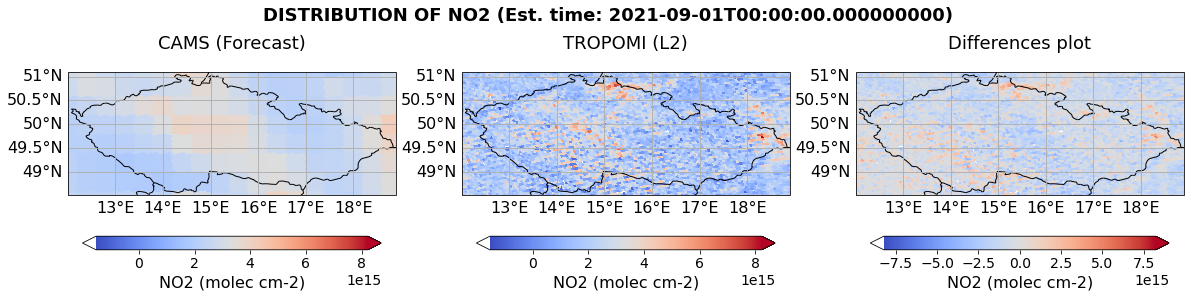

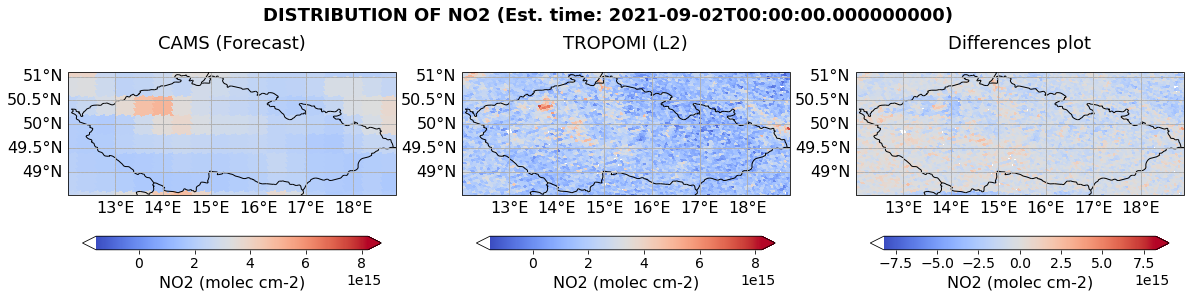

In [31]:
# Choose distribution (aggregated or individual)
distribution_type = 'individual'

# Choose range (original, equal or manual)
range_type = 'equal'
vmin_manual = None
vmax_manual = None

# Define projection and colors
projection = ccrs.PlateCarree()
color_scale = 'coolwarm' 

visualize_model_vs_sensor(model, sensor, component_nom, units, merge_table, plot_dates, plot_bbox, 20, 0.80, 
                          model_type, sensor_type, range_type, sensor_column, distribution_type, projection,
                          color_scale, vmin_manual, vmax_manual)

### Compare CAMS original and averaged total columns

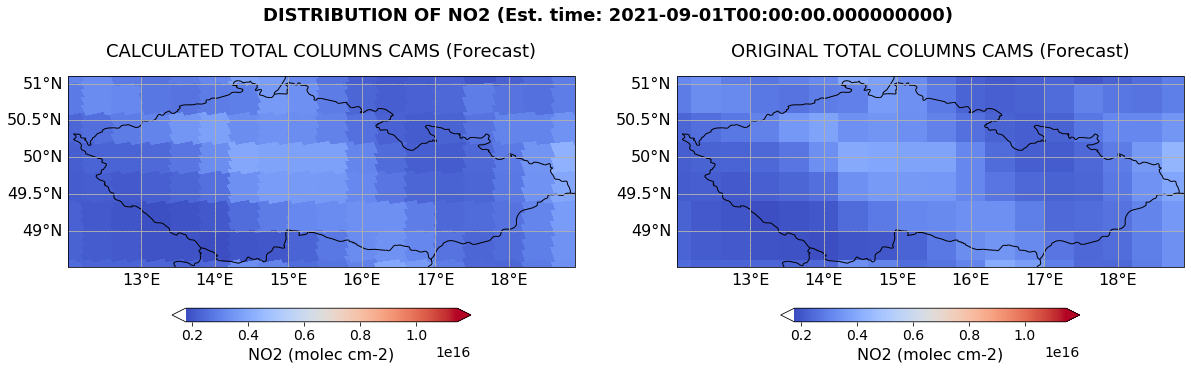

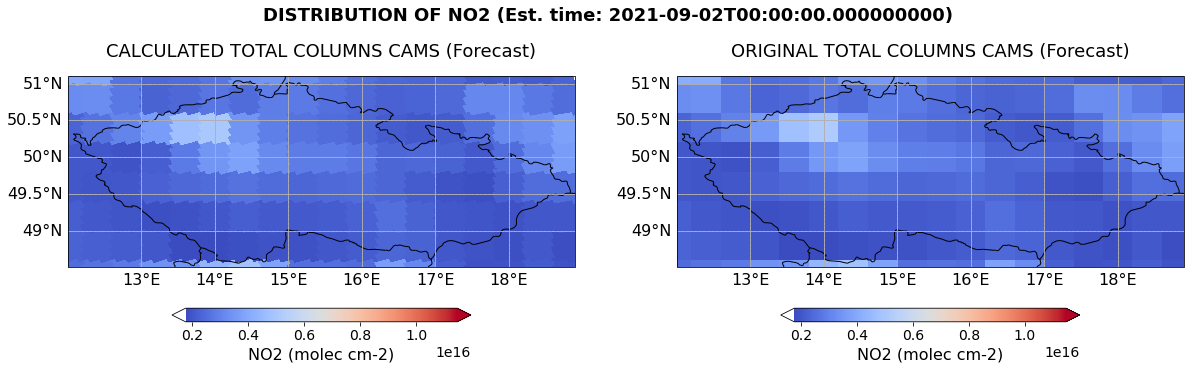

In [30]:
# Choose range (original, equal or manual)
range_type = 'equal' # original or equal
vmin_manual = None
vmax_manual = None

# Define projection and colors
projection = ccrs.PlateCarree()
color_scale = 'coolwarm' 

visualize_model_original_vs_calculated(model, component_nom,units, merge_table, model_total_ds, plot_dates, 
                                       plot_bbox, 20, 1, model_type, range_type, projection, color_scale,
                                       vmin_manual, vmax_manual)

## 7. Retrieve nearest values to specific latitude and longitude

In [22]:
coords_search_list = (50, 60,
                      4, 10,
                      20, 30)
retrieval_table_all =  retrieve_coords(merge_table.dropna(), coords_search_list, component_nom, 
                                       sensor_column, sensor, model, plot_dates, units)
retrieval_table_all

scanline  ground_pixel  \
lat_search lon_search latitude  longitude time                                 
50         60         48.614834 19.691992 2021-09-01      36.0         323.0   
                      48.691010 19.868855 2021-09-02     118.0         241.0   
4          10         47.468117 12.511526 2021-09-01      36.0         180.0   
                      46.947231 12.886065 2021-09-02     118.0         104.0   
20         30         48.614834 19.691992 2021-09-01      36.0         323.0   
                      48.691010 19.868855 2021-09-02     118.0         241.0   

                                                      model_column  \
lat_search lon_search latitude  longitude time                       
50         60         48.614834 19.691992 2021-09-01  3.415405e+15   
                      48.691010 19.868855 2021-09-02  1.818281e+15   
4          10         47.468117 12.511526 2021-09-01  2.300582e+15   
                      46.947231 12.886065 2021-09-02  2.782956e+15   
20         30         48.614834 19.691992 2021-09-01  3.415405e+15   
                      48.691010 19.868855 2021-09-02  1.818281e+15   

                                                      nitrogendioxide_tropospheric_column  \
lat_search lon_search latitude  longitude time                                              
50         60         48.614834 19.691992 2021-09-01                         2.350504e+15   
                      48.691010 19.868855 2021-09-02                         4.308903e+14   
4          10         47.468117 12.511526 2021-09-01                         8.901390e+14   
                      46.947231 12.886065 2021-09-02                         2.010204e+15   
20         30         48.614834 19.691992 2021-09-01                         2.350504e+15   
                      48.691010 19.868855 2021-09-02                         4.308903e+14   

                                                        difference  
lat_search lon_search latitude  longitude time                      
50         60         48.614834 19.691992 2021-09-01 -1.064901e+15  
                      48.691010 19.868855 2021-09-02 -1.387391e+15  
4          10         47.468117 12.511526 2021-09-01 -1.410443e+15  
                      46.947231 12.886065 2021-09-02 -7.727521e+14  
20         30         48.614834 19.691992 2021-09-01 -1.064901e+15  
                      48.691010 19.868855 2021-09-02 -1.387391e+15

## 8. Scatter plots by bbox

Fit equation: NO2_model = NO2_sensor * 0.17 + (2.35E+15)
Coefficient of determination (R2): 0.07


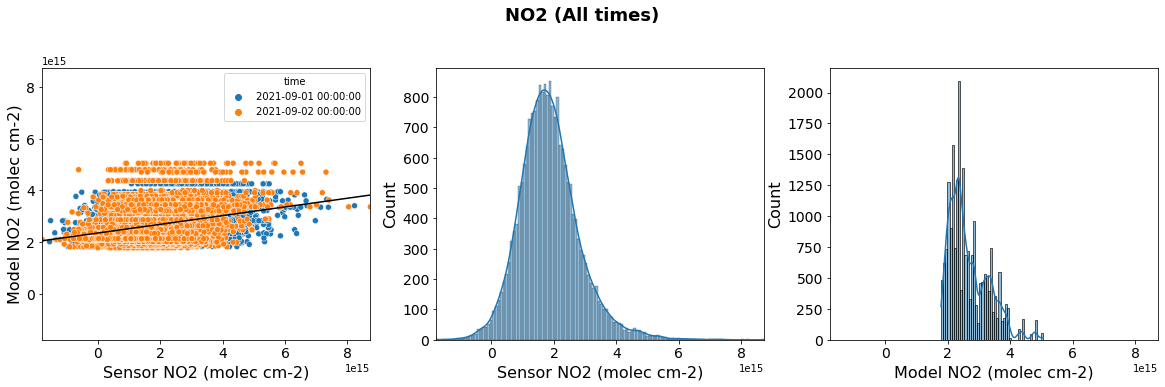

In [23]:
show_seasons = False
extent_definition = 'bbox' # bbox or country
scatter_plot_type = 'aggregated' # aggregated or individual
summary = scatter_plot(merge_table.dropna(), component_nom, units, sensor_column, sensor, 
                       plot_dates, 1.05, extent_definition, show_seasons, scatter_plot_type, plot_bbox)

In [24]:
summary

,Period,Location,Score,Coefficient,Intercept
0,"[2021-09-01T00:00:00.000000000, 2021-09-02T00:...","((12, 48.5), (18.9, 51.1))",0.066685,0.168298,2.350074e+15


## 9. Scatter plots by season

Fit equation: NO2_model = NO2_sensor * 0.17 + (2.35E+15)
Coefficient of determination (R2): 0.07


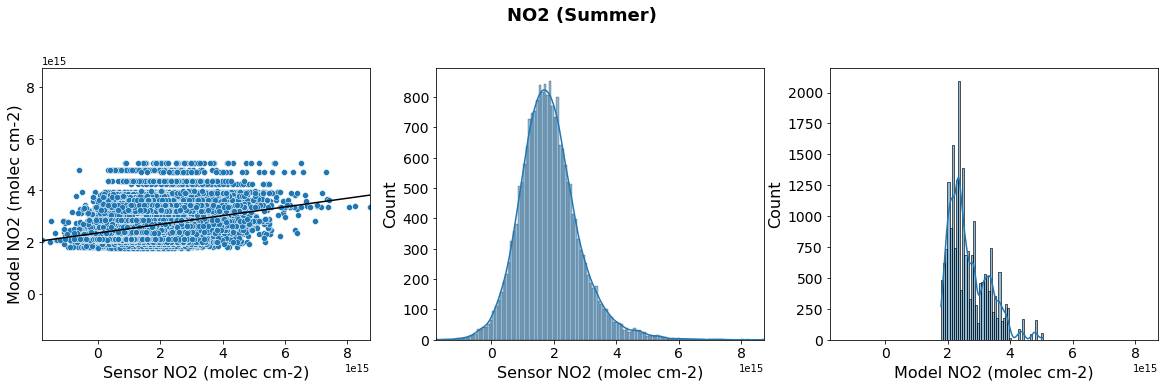

In [25]:
show_seasons = True
extent_definition = 'bbox' # bbox or country
scatter_plot_type = 'individual' # aggregated or individual
summary = scatter_plot(merge_table.dropna(), component_nom, units, sensor_column, sensor, 
                       plot_dates, 1.05, extent_definition, show_seasons, scatter_plot_type, plot_bbox)

In [26]:
summary

,Period,Location,Score,Coefficient,Intercept
0,Summer,"((12, 48.5), (18.9, 51.1))",0.066685,0.168298,2.350074e+15


## 10. Scatter plots by country (Google API required!)

In [27]:
"""
show_seasons = False
extent_definition = 'country' # bbox or country
scatter_plot_type = 'aggregated' # aggregated or individual
plot_countries = ['Czech Republic', 'Poland', 'Germany']
scatter_plot(merge_table.dropna(), component_nom, units, sensor_column, sensor, 
             plot_dates, 1.05, extent_definition, show_seasons, scatter_plot_type, plot_countries)
"""

"\nshow_seasons = False\nextent_definition = 'country' # bbox or country\nscatter_plot_type = 'aggregated' # aggregated or individual\nplot_countries = ['Czech Republic', 'Poland', 'Germany']\nscatter_plot(merge_table.dropna(), component_nom, units, sensor_column, sensor, \n             plot_dates, 1.05, extent_definition, show_seasons, scatter_plot_type, plot_countries)\n"

In [28]:
#summary